In [1]:
import geopandas as gpd
import pandas as pd, numpy as np

import rasterio as rio
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

from tqdm import tqdm
from rasterio.mask import mask

In [2]:
dist = "../Data/gjson/adm_3.geojson"
tiff = "../Data/Raster/Population/eth_ppp_2020_constrained.tif"

In [3]:
dist_gdf = gpd.read_file(dist)
sample = dist_gdf.sample(1)
sample

,id,fnid,name,unit_type_code,parent_id,start_date,end_date,country_code,fewsnet_region,geographic_group,...,layer_id,layer_name,geographicunitsetversion_name,zone_type,urban_rural,start_month,area,attributes,fid,geometry
1039,223835,ET2023A3181301,Karat town,admin3,222778,2023-10-01,None,ET,East Africa,Eastern Africa,...,4697,ET_Admin3_2023,Ethiopia FEWS NET Admin Boundaries: From 10/01...,None,None,None,3.0,"{'FNID': 'ET2023A3181301', 'ADMIN0': 'Ethiopia...",1039,"POLYGON ((37.44447 5.32454, 37.44400 5.32300, ..."


In [4]:
dist_gdf.columns

Index(['id', 'fnid', 'name', 'unit_type_code', 'parent_id', 'start_date',
       'end_date', 'country_code', 'fewsnet_region', 'geographic_group',
       'full_name', 'es_name', 'fr_name', 'pt_name', 'ar_name', 'unit_type',
       'country', 'admin_0', 'admin_1', 'admin_2', 'admin_3', 'admin_4',
       'layer_id', 'layer_name', 'geographicunitsetversion_name', 'zone_type',
       'urban_rural', 'start_month', 'area', 'attributes', 'fid', 'geometry'],
      dtype='object')

In [5]:
cols_dataref = [
    "id",
    "fnid",
    "parent_id",
    "admin_0",
    "admin_1",
    "admin_2",
    "admin_3",
]

metrics = [np.mean, np.std, np.sum]

metric_value = "population"

with rio.open(tiff) as src:

    out_image, out_transform = mask(src, sample.geometry, crop=True)


ref_df = sample[cols_dataref]

values = out_image.flatten()

rows, cols = np.indices(out_image.shape[-2:])

x, y = rio.transform.xy(out_transform, rows.flatten(), cols.flatten())

data = {"x": x, "y": y, "z": values}

data = pd.DataFrame(data).query("z>0").dropna()

In [6]:
stats = data["z"].agg(metrics).values.flatten()
(
    ref_df[f"{metric_value}_mean"],
    ref_df[f"{metric_value}_sd"],
    ref_df[f"{metric_value}_sum"],
) = stats
ref_df

,id,fnid,parent_id,admin_0,admin_1,admin_2,admin_3,population_mean,population_sd,population_sum
1039,223835,ET2023A3181301,222778,Ethiopia,South Ethiopia,Konso,Karat town,60.405293,27.208727,12805.921875


<Axes: >

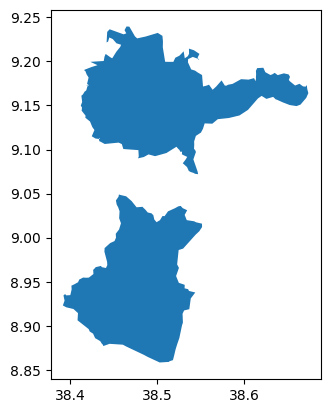

In [7]:
def get_data_raster_shapefile(
    path_tiff: str = tiff,
    shp_gdf: gpd.GeoDataFrame = sample,
    cols_dataref=cols_dataref,
    metrics=[np.mean, np.std, np.sum],
    metric_value="population",
):

    with rio.open(path_tiff) as src:
        out_image, out_transform = mask(src, shp_gdf.geometry, crop=True)
    temp_gdf = shp_gdf.copy()
    shp_gdf = shp_gdf[cols_dataref]
    values = out_image.flatten()
    rows, cols = np.indices(out_image.shape[-2:])
    x, y = rio.transform.xy(out_transform, rows.flatten(), cols.flatten())
    data = {"x": x, "y": y, "z": values}
    data = pd.DataFrame(data).query("z>0").dropna()
    stats = data["z"].agg(metrics).values.flatten()
    (
        shp_gdf[f"{metric_value}_mean"],
        shp_gdf[f"{metric_value}_sd"],
        shp_gdf[f"{metric_value}_sum"],
    ) = stats
    return shp_gdf, (temp_gdf, out_image, out_transform)


result, metadata = get_data_raster_shapefile(shp_gdf=dist_gdf.sample(1))
# result
metadata[0].plot()

In [8]:
# total_rows = len(dist_gdf.sample(10))
total_rows = len(dist_gdf)
result_df = pd.DataFrame()
for row in tqdm(range(total_rows)):
    # print(row)
    row_gdf = dist_gdf.iloc[row : row + 1]
    result, metadata = get_data_raster_shapefile(shp_gdf=row_gdf)
    result_df = pd.concat((result_df, result))
result_df

  5%|▍         | 54/1141 [00:44<08:36,  2.10it/s] 

In [9]:
result_df.to_csv("../output/population/pop.csv")